In [1]:
import iris
import weightingFunctions as wf
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import scipy.interpolate as interpolate
import pygam as gam
from itertools import permutations

In [4]:
data_dir = '/home/amosm1/Analysis/Ozone_Weighting/For Publication/data/'

# Load Observations

In [5]:
# MSU TLS cSPC(-60, -82.5)
ta = iris.load_cube(data_dir + 'observations/ta_TLS_son_msu_cSPC.nc')
ta.attributes['model_id'] = 'OBS'

# toz
toz = iris.load_cube(data_dir + 'observations/toz_on_SPC.nc')
toz.attributes['model_id'] = 'OBS'
toz_norm = np.mean(wf.constrain_year(toz, 1979, 1981).data)

# BDBP ozone trend 
toz_grad = iris.load_cube(data_dir + 'observations/dtozdt_on_SPC.nc')
toz_grad.attributes['model_id'] = 'OBS'

# MSU TLS cSPC(-60 - -82.5) trend
ta_grad = iris.load_cube(data_dir + 'observations/dtadt_TLS_son_cSPC.nc')
ta_grad.attributes['model_id'] = 'OBS'

# Gozcards HCL averaged over what data exists 300-1hPa SPC in the austral spring
hcl = iris.load_cube(data_dir + 'observations/hcl_son_SPC.nc')
hcl.attributes['model_id'] = 'OBS'

zmua = float(0.009625)

dtozdT = float(7.52)

dtozdtdTdt = float(48.9)

# Load Models

In [6]:
# toz_refC1SD - SPC, averaged realisations, oct,nov
toz_refC1SD = pkl.load(open(data_dir + 'models/toz_on_SPC_refC1SD.p', "rb"))

# toz_grad_refC1SD - same as above, just the gradient
toz_grad_refC1SD = pkl.load(open(data_dir + 'models/dtozdt_on_SPC_refC1SD.p', "rb"))

# ta1_refC1SD - 'son' TLS from MSU
ta_refC1SD = pkl.load(open(data_dir + 'models/ta_son_cSPC_refC1SD.p', "rb"))

# T grad
ta_grad_refC1SD = pkl.load(open(data_dir + 'models/dTdt_on_cSPC_refC1SD.p', "rb"))

# hcl averaged over what data exists 300-1hPa SPC in the austral spring (Doesn't include GRIM or MOCAGE)
hcl_refC1SD = pkl.load(open(data_dir + 'models/hcl_son_SPC_refC1SD.p', "rb"))

# dtozdT - Dictionary of gradients 1980-2009 for SPC, oct, toz and TLS
dtozdT_refC1SD = pkl.load(open(data_dir + 'models/dtozdT_on_cSPC_refC1SD.p', "rb"))

# dtozdtdTdt - Dictionary of gradients 1980-2009 for SPC, oct, toz and TLS
dtozdtdTdt_refC1SD = pkl.load(open(data_dir + 'models/dtozdtdTdt_on_cSPC_refC1SD.p', "rb"))

# zmua trend - t20hPa 60S winds 
zmua_refC1SD = pkl.load(open(data_dir + 'models/zmuatrend_mon_20hPa_60S_refC1SD.p', "rb"))

# toz_refC2 - SPC, averaged realisations, oct, normalised
toz_refC2 = pkl.load( open(data_dir + 'models/toz_refC2.p', "rb"))
# Rename the CESM models for ease of processing later
for m in toz_refC2:
    if 'CESM1' in wf.get_mdls_reals(m):
        mdl_SD = m.attributes['model_id'] + 'SD'
        m.attributes['model_id'] = mdl_SD

### We can remove the models that don't appear in both the input and output
- CNRM-CM5-3r2i1p2
- EMAC-L47MAr1i1p2
- EMAC-L90MAr1i1p2
- GRIMs-CCMr1i1p1
- MOCAGEr1i1p1

In [7]:
mdls_to_remove = ['CNRM-CM5-3r2i1p2', 'EMAC-L47MAr1i1p2', 'EMAC-L90MAr1i1p2', 'GRIMs-CCMr1i1p1', 'MOCAGEr1i1p1']

wf.remove_mdlreal(toz_refC1SD, mdls_to_remove)
wf.remove_mdlreal(toz_grad_refC1SD, mdls_to_remove)
wf.remove_mdlreal(ta_refC1SD, mdls_to_remove)
wf.remove_mdlreal(ta_grad_refC1SD, mdls_to_remove)
wf.remove_mdlreal(hcl_refC1SD, mdls_to_remove)

for m in mdls_to_remove:
    try:
        del dtozdT_refC1SD[m]
    except:
        print(m + ' not in dtozdT')
    try:
        del dtozdtdTdt_refC1SD[m]
    except:
        print(m + ' not in dtozdtdTdt')
    try:
        del zmua_refC1SD[m]
    except:
        print(m + ' not in zmua')
        
# Ensure that the refC2 models are the same as the refC1 models
toz_refC2_temp = []
for cube2 in toz_refC2:
    for cube1 in toz_refC1SD:
        if wf.get_mdls_reals(cube1) == wf.get_mdls_reals(cube2):
            toz_refC2_temp.append(cube2)

### Constrain time
So that the observations and models are directly comparable

In [8]:
ta_mdls, ta_obs = wf.constrain_mdl_obs_time(ta_refC1SD, ta)
toz_grad_mdls, toz_grad_obs = wf.constrain_mdl_obs_time(toz_grad_refC1SD, toz_grad)
ta_grad_mdls, ta_grad_obs = wf.constrain_mdl_obs_time(ta_grad_refC1SD, ta_grad)
# We have already constrained the time for the hcl metric

### Create the smoothed trend of toz observations

In [9]:
X = toz.coord('year').points
Y = toz.data

lam = np.logspace(np.log10(0.1), np.log10(1), 50)
n_splines = np.arange(1, 10)

mod = gam.LinearGAM()
mod.fit(X, Y)
mod.gridsearch(X, Y, lam=lam, n_splines=n_splines)

opt_lam = mod.lam
opt_n_splines = len(mod.coef_) - 1


mod = gam.LinearGAM(lam=opt_lam, n_splines=opt_n_splines)
mod.fit(X, Y)

smoothed_toz = mod.predict(X) 

100% (450 of 450) |######################| Elapsed Time: 0:00:06 Time:  0:00:06


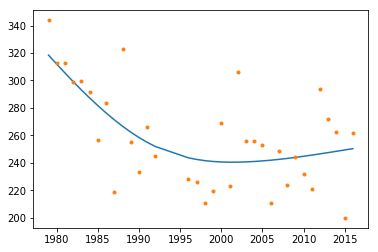

In [10]:
plt.plot(X, smoothed_toz)
iris.plot.plot(toz.coord('year'), toz, '.')

### Create the smoothed projections for each model.
We use a generalised additive model (GAM) to seperate the trendline from the inter-annual variability. First we we find values ofnparameters of (lambda and number_of_splines) for which the trendlines are good fits to the model output.

This step takes a few minutes to run

In [11]:
opt_lam = []
opt_n_splines = []

lam = np.logspace(np.log10(0.1), np.log10(10), 100)
n_splines = np.arange(20, 30)

for cube in toz_refC2_temp:
    Y = cube.data
    X = cube.coord('year').points
    mod = gam.LinearGAM()
    mod.fit(X, Y)
    mod.gridsearch(X, Y, lam=lam, n_splines=n_splines)
    
    opt_lam.append(mod.lam)
    opt_n_splines.append(len(mod.coef_) - 1)

100% (1000 of 1000) |####################| Elapsed Time: 0:00:22 Time:  0:00:22
100% (1000 of 1000) |####################| Elapsed Time: 0:00:22 Time:  0:00:22
100% (1000 of 1000) |####################| Elapsed Time: 0:00:21 Time:  0:00:21
100% (1000 of 1000) |####################| Elapsed Time: 0:00:22 Time:  0:00:22
100% (1000 of 1000) |####################| Elapsed Time: 0:00:21 Time:  0:00:21
100% (1000 of 1000) |####################| Elapsed Time: 0:00:22 Time:  0:00:22
100% (1000 of 1000) |####################| Elapsed Time: 0:00:21 Time:  0:00:21
100% (1000 of 1000) |####################| Elapsed Time: 0:00:21 Time:  0:00:21
100% (1000 of 1000) |####################| Elapsed Time: 0:00:21 Time:  0:00:21
100% (1000 of 1000) |####################| Elapsed Time: 0:00:22 Time:  0:00:22
100% (1000 of 1000) |####################| Elapsed Time: 0:00:21 Time:  0:00:21


For each model we record the model trend (h) the standard error (se) which is back computed from the given confidence interval (these are an estimate), and the anomallies (anoms) which are the noise term $\epsilon_j$. The trends are then baseline adjusted to the 1980 observational value.

In [12]:
h = []
se = []
anoms = []

xx = np.arange(1950, 2110)
for i, cube in enumerate(toz_refC2_temp):
    X = cube.coord('year').points
    Y = cube.data
    
    y0 = X[0]
    y1 = X[-1]
    
    mod = gam.LinearGAM(lam=opt_lam[i], n_splines=opt_n_splines[i])
    mod.fit(X, Y)
    hh = mod.predict(xx)
    
    hh[xx < y0] = np.nan
    hh[xx > y1] = np.nan
    
    y_pred = mod.predict(xx)
    
    ci = mod.confidence_intervals(xx)

    s_j = (y_pred - ci[:,0]) / 1.96
    se.append(s_j)
    anoms = anoms + list((Y - mod.predict(X)).data)
    h.append(hh)
    
# Adjust baseline
baseline_adjusted_y = []
baseline_adjusted_h = []

for i, cube in enumerate(toz_refC2_temp):
    y_dash = cube.data - h[i][30]
    baseline_adjusted_y.append(y_dash)
    
    h_dash = h[i] - h[i][30]
    baseline_adjusted_h.append(h_dash)

Set the refC2 toz to be the smoothed trendlines found above

In [13]:
for i, cube in enumerate(toz_refC2_temp):
    x = baseline_adjusted_h[i]
    cube.data = x[~np.isnan(x)]
    
toz_refC2 = toz_refC2_temp

View the smoothed trendlines of refC2 for each model

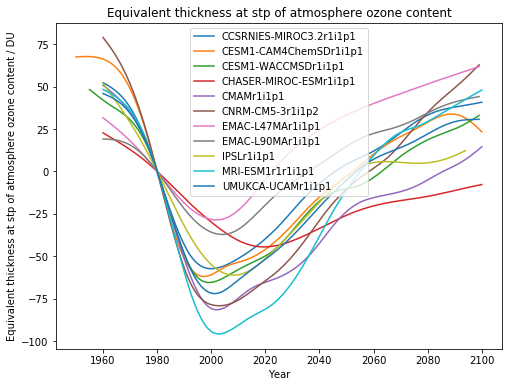

In [14]:
wf.plot_cubes(toz_refC2)

We normalise all of the models and observations to between -1, 1.

In [15]:
toz_grad_mdls_norm, toz_grad_obs_norm = wf.normalise_MM_mdls_obs(toz_grad_mdls, toz_grad_obs)
ta_mdls_norm, ta_obs_norm = wf.normalise_MM_mdls_obs(ta_mdls, ta_obs)
ta_grad_mdls_norm, ta_grad_obs_norm = wf.normalise_MM_mdls_obs(ta_grad_mdls, ta_grad_obs)
hcl_mdls_norm, hcl_obs_norm = wf.normalise_MM_mdls_obs(hcl_refC1SD, hcl)
zmua_mdls_norm, zmua_obs_norm = wf.normalise_MM_mdls_obs_single_value(zmua_refC1SD, zmua)
dtozdT_mdls_norm, dtozdT_obs_norm = wf.normalise_MM_mdls_obs_single_value(dtozdT_refC1SD, dtozdT)
dtozdtdTdt_mdls_norm, dtozdtdTdt_obs_norm = wf.normalise_MM_mdls_obs_single_value(dtozdtdTdt_refC1SD, dtozdtdTdt)

We sort the cubes in the metrics into alphabetical order, so that we can directly compare between them. The single value metrics are already in alphabetical order, so need no sorting

In [16]:
toz_grad_mdls_norm = wf.sort_cubes(toz_grad_mdls_norm)
ta_mdls_norm = wf.sort_cubes(ta_mdls_norm)
ta_grad_mdls_norm, mdl_names = wf.sort_cubes(ta_grad_mdls_norm, print_mdls=1)
hcl_mdls_norm = wf.sort_cubes(hcl_mdls_norm)

# Calculating weights

## Independence weighting

In [17]:
# Specify the value for sigma_s (a length scale over which two models,
# or a model and observation, are deemed to be in similar.)
sigma_s = 0.12

Calculate the inter model similarities and  similarity weights for each metric

In [18]:
S_ta, W_ta = wf.independence(ta_mdls_norm, sigma=sigma_s)
S_ta_grad, W_ta_grad = wf.independence(ta_grad_mdls_norm, sigma=sigma_s)
S_toz_grad, W_toz_grad = wf.independence(toz_grad_mdls_norm, sigma=sigma_s)
S_hcl, W_hcl = wf.independence(hcl_mdls_norm, sigma=sigma_s)
S_zmua, W_zmua = wf.independence_single_value(zmua_mdls_norm.values(), sigma=sigma_s)
S_dtozdT, W_dtozdT = wf.independence_single_value(dtozdT_mdls_norm.values(), sigma=sigma_s)
S_dtozdtdTdt, W_dtozdtdTdt = wf.independence_single_value(dtozdtdTdt_mdls_norm.values(), sigma=sigma_s)

Average over all of the metrics and find the weight due to independence

In [19]:
S_list = [S_ta, S_ta_grad, S_toz_grad, S_hcl, S_zmua, S_dtozdT, S_dtozdtdTdt]

S_ave = np.zeros(S_list[0].shape)
for s in S_list:
    S_ave += s
    
S_ave /= len(S_list)
W_ave = np.zeros((len(mdl_names), 1))

for ii in range(len(mdl_names)):
    w = 1 / (1 + np.nansum(S_ave[ii], 0))
    W_ave[ii] = w

W_ave /= np.nansum(W_ave)

W_ave here is $ w_i = \frac{1}{1 + \sum_{k=1}^{N}\exp \left( \frac{-S_{ijk}^2}{\sigma_{sk}n_k} \right)}$

## Performace weighting

In [20]:
# Specify the value for sigma_d (a length scale over which two models,
# or a model and observation, are deemed to be in good agreement.)
sigma_d = 0.088

In [21]:
Wd_ta = wf.performance(ta_mdls_norm, ta_obs_norm, sigma=sigma_d)
Wd_ta_grad = wf.performance(ta_grad_mdls_norm, ta_grad_obs_norm, sigma=sigma_d)
Wd_toz_grad = wf.performance(toz_grad_mdls_norm, toz_grad_obs_norm, sigma=sigma_d)
Wd_hcl = wf.performance(hcl_mdls_norm, hcl_obs_norm, sigma=sigma_d)
Wd_zmua = wf.performance_single_value(zmua_mdls_norm.values(), zmua_obs_norm, sigma=sigma_d)
Wd_dtozdT = wf.performance_single_value(dtozdT_mdls_norm.values(), dtozdT_obs_norm, sigma=sigma_d)
Wd_dtozdtdTdt = wf.performance_single_value(dtozdtdTdt_mdls_norm.values(), dtozdtdTdt_obs_norm, sigma=sigma_d)

Average over all of the metrics and find the weight due to performance

In [22]:
D_list = [Wd_ta, Wd_ta_grad, Wd_toz_grad, Wd_hcl, Wd_zmua, Wd_dtozdT, Wd_dtozdtdTdt]

D_ave = np.zeros(D_list[0].shape)
for d in D_list:
    D_ave += d
    
D_ave /= len(D_list)
D_ave /= np.nansum(D_ave)

## Combine to find the total weighting

In [23]:
W_tot = (D_ave * W_ave).reshape(-1)
W_tot = W_tot/np.sum(W_tot)

# We save this weight for later
W_save = W_tot

## Look at how the metrics influence the weighting

In [24]:
metric_labels = ['Temperature', 'Temperature gradient', 'Ozone column gradient', 'Hydrogen Chloride', 'Polar vortex breakdown trend', 'Ozone-temperature gradient', 'Ozone-temperature tendency']
metric_weights = []
for i in range(0, len(S_list)):
    s = S_list[i]
    w_s = 1 / (1 + np.nansum(s, 0))
    d = D_list[i]
    
    w_total = d.ravel() * w_s
    w_total = w_total/np.sum(w_total)

    metric_weights.append(w_total)

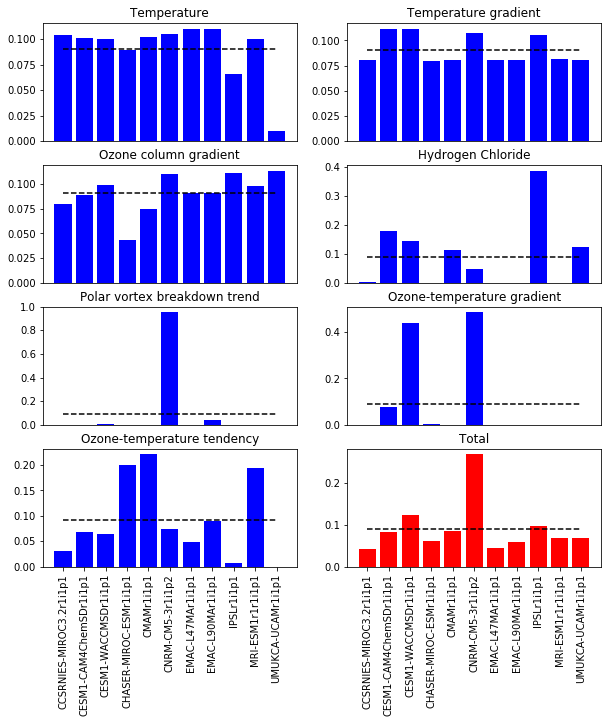

In [25]:
plt.figure(figsize=(10,10))

for i in range(0,7):
    plt.subplot(4, 2, i+1)
    plt.plot(mdl_names, [1./len(mdl_names)] * len(mdl_names), 'k--')
    plt.bar(mdl_names, metric_weights[i], color='b')
    plt.title(metric_labels[i])
    
    if i == 6:
        plt.xticks(rotation='vertical')
    else:
        plt.xticks([])

plt.subplot(4, 2, 8)
plt.plot(mdl_names, [1./len(mdl_names)] * len(mdl_names), 'k--')
plt.bar(mdl_names, W_tot, color='r')
plt.title('Total')
plt.xticks(rotation='vertical')

plt.show()

# Create a weighted projection

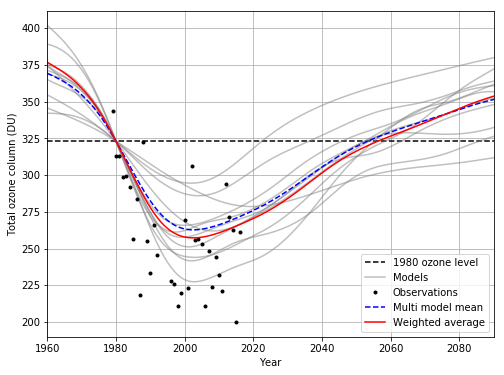

In [26]:
W_dict = {}
for i in range(len(mdl_names)):
    W_dict[mdl_names[i]] = W_tot[i]

w_cubes = []
for cube in toz_refC2:
    if wf.get_mdls_reals(cube) in W_dict.keys():
        w_cubes.append(cube)
        
w_cubes = wf.constrain_mdl_time(w_cubes)
we_ave = np.zeros(w_cubes[0].shape)
MMM = np.zeros(w_cubes[0].shape)
for cube in w_cubes:
    w = W_dict[wf.get_mdls_reals(cube)]
    we_ave = we_ave + (w * cube.data)
    MMM = MMM + cube.data
MMM = MMM / len(w_cubes)

we_ave_tot = we_ave

plt.figure(figsize=(8,6))
plt.plot([1960, 2090], [toz_norm, toz_norm], linestyle='--', color='black', label='1980 ozone level')
first = True
for cube in w_cubes:
    if first == True:
        first = False
        if wf.get_mdls_reals(cube) in W_dict.keys():
            plt.plot(cube.coord('year').points, cube.data + toz_norm, 'gray',label='Models', alpha=0.5)
    else:
        if wf.get_mdls_reals(cube) in W_dict.keys():
            plt.plot(cube.coord('year').points, cube.data + toz_norm, 'gray', alpha=0.5)
            
plt.plot(toz.coord('year').points[:14], toz.data[:14], 'k.', label='Observations')
plt.plot(toz.coord('year').points[14:], toz.data[14:], 'k.')
plt.plot(cube.coord('year').points, MMM + toz_norm, color='b', linestyle='--', label='Multi model mean')
plt.plot(cube.coord('year').points, we_ave + toz_norm, color='r', label='Weighted average')
plt.ylabel('Total ozone column (DU)')
time_fin = cube.coord('year').points


plt.grid(True)
plt.xlim(1960,2090)
plt.legend()
plt.xlabel('Year')
plt.show()

# Testing

## Out of sample testing

In [27]:
toz_test = toz[:]
toz_test_years = toz_test.coord('year').points
refC2_years = w_cubes[0].coord('year').points

MMM_test = MMM[[i in toz_test_years for i in refC2_years ]]
we_ave_test = we_ave[[i in toz_test_years for i in refC2_years ]]

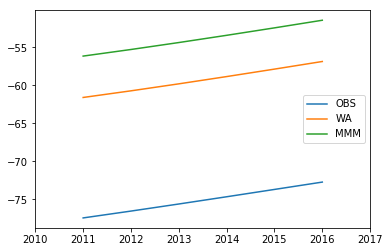

In [43]:
plt.figure()
plt.plot(toz_test_years[-6:], smoothed_toz.data[-6:] - toz_norm, label='OBS')
plt.plot(toz_test_years[-6:], we_ave_test.data[-6:], label='WA')
plt.plot(toz_test_years[-6:], MMM_test[-6:], label='MMM')
plt.xlim([2010,2017])
plt.legend()
plt.show()

In [41]:
print('For 2010-2016 ')
print('SE of MMM = {}'.format(np.sum((smoothed_toz[-6:] - toz_norm - MMM_test[-6:]) ** 2)))
print('SE of WA = {}'.format(np.sum((smoothed_toz[-6:] - toz_norm - we_ave_test[-6:]) ** 2)))

For 2010-2016 
SE of MMM = 2719.5007590992936
SE of WA = 1507.3608925264657


In [46]:
(2720 - 1510 ) / 6

201.66666666666666

## Dropout testing of return dates

In [29]:
def return_dates_dropout(mdl_vars, obs_vars, mdl_perms, metric_perms):
    
    Ws = []
    Ts = []
    dates = []
    first = True
    plt.figure(figsize=(8,6))
    
    for mdl_perm in mdl_perms:
        for metric_perm in metric_perms:
            
            # Remove the dropped metrics
            temp_mdl_vars = np.array(mdl_vars.copy())[np.array(metric_perm)]
            temp_obs_vars = np.array(obs_vars.copy())[np.array(metric_perm)]
            
            # Remove the dropped models from the obs and mdl predictions
            new_mdl_vars = []
            for met in temp_mdl_vars:
                if isinstance(met, list):
                    temp_met = np.array(met.copy())[np.array(mdl_perm)]
                else:
                    temp_met = dict()
                    for key in np.array(list(met.keys()))[np.array(mdl_perm)]:
                        temp_met[key] = met.copy()[key]
                new_mdl_vars.append(temp_met)
            try:
                mdl_names = [wf.get_mdls_reals(c) for c in new_mdl_vars[0]]
            except AttributeError:
                mdl_names = list(new_mdl_vars[0].keys())
            n_mdls = len(mdl_names)
            
            # Compute independence
            S_list = []
            for met in new_mdl_vars:
                if isinstance(met, np.ndarray):
                    S, W = wf.independence(list(met), sigma=sigma_s)
                else:
                    S, W = wf.independence_single_value(met.values(), sigma=sigma_s)
                S_list.append(S)
            
            S_ave = np.zeros(S_list[0].shape)
            for s in S_list:
                S_ave += s
                
            W_ave = np.zeros((n_mdls, 1))#################

            for ii in range(n_mdls):
                w = 1 / (1 + np.nansum(S_ave[ii], 0))
                W_ave[ii] = w

            W_ave /= np.nansum(W_ave)

            W_independence = dict()
            for ii, mdl in enumerate(mdl_names):
                W_independence[mdl] = W_ave[ii]
                
            # Performance
            D_list = []

            for k, met in enumerate(new_mdl_vars):
                if isinstance(met, np.ndarray):
                    D = wf.performance(met, temp_obs_vars[k], sigma=sigma_d)
                else:
                    D = wf.performance_single_value(met.values(), temp_obs_vars[k], sigma=sigma_d)
                D_list.append(D)

            D_ave = np.zeros(D_list[0].shape)
            for d in D_list:
                D_ave += d

            D_ave /= len(D_list)

            D_ave /= np.nansum(D_ave)

            W_tot = (D_ave * W_ave).reshape(-1)

            W_dict = dict()
            for ii, w in enumerate(W_tot): 
                W_dict[mdl_names[ii]] = w

            # Calculate predictions
            # Construct weighted ave
            # Find which model appear both in the weighting and the refC2
            refC2_reals = []
            for cube in toz_refC2:
                refC2_reals.append(wf.get_mdls_reals(cube))

            mdl_intersect = np.intersect1d(refC2_reals, mdl_names)

            W_intersect = dict()
            for mdl in mdl_intersect:
                W_intersect[mdl] = W_dict[mdl]

            # Normalise the new weights which are left
            w_tot = np.sum(list(W_intersect.values()))
            for key in W_intersect.keys():
                W_intersect[key] = W_intersect[key] / w_tot

            w_cubes = []
            for cube in toz_refC2:
                if wf.get_mdls_reals(cube) in W_intersect.keys():
                    w_cubes.append(cube)
                    
            w_cubes = wf.constrain_mdl_time(w_cubes)
            time = w_cubes[0].coord('year').points
            we_ave = np.zeros(w_cubes[0].shape)
            for cube in w_cubes:
                w = W_intersect[wf.get_mdls_reals(cube)]
                we_ave = we_ave + (w * cube.data)
#             plt.figure()
            if first:
                first = False
                plt.plot(time, we_ave + toz_norm, 'gray', alpha=0.3, label='Surrogate weighted average')
            else:
                plt.plot(time, we_ave + toz_norm, 'gray', alpha=0.3)
               
            # Calculate return dates
            # [50:] ensures that we are just looking at a 1:1 Mapping
            fun = interpolate.interp1d(we_ave[50:], time[50:])
            dates.append(fun(0))
#             plt.grid(True)
#             plt.plot([1960, 2090], [0,0], linestyle='--', color='black', label='1980 ozone level')
#             plt.title(fun(0))
#             plt.show()
            Ws.append(we_ave)
            Ts.append(time)
        
    S_ta, W_ta = wf.independence(ta_mdls_norm, sigma=sigma_s)
    S_ta_grad, W_ta_grad = wf.independence(ta_grad_mdls_norm, sigma=sigma_s)
    S_toz_grad, W_toz_grad = wf.independence(toz_grad_mdls_norm, sigma=sigma_s)
    S_hcl, W_hcl = wf.independence(hcl_mdls_norm, sigma=sigma_s)
    S_zmua, W_zmua = wf.independence_single_value(zmua_mdls_norm.values(), sigma=sigma_s)
    S_dtozdT, W_dtozdT = wf.independence_single_value(dtozdT_mdls_norm.values(), sigma=sigma_s)
    S_dtozdtdTdt, W_dtozdtdTdt = wf.independence_single_value(dtozdtdTdt_mdls_norm.values(), sigma=sigma_s)
    S_list = [S_ta, S_ta_grad, S_toz_grad, S_hcl, S_zmua, S_dtozdT, S_dtozdtdTdt]
    mdl_names = [wf.get_mdls_reals(c) for c in ta_mdls_norm]
    S_ave = np.zeros(S_list[0].shape)
    for s in S_list:
        S_ave += s

    S_ave /= len(S_list)

    W_ave = np.zeros((len(mdl_names), 1))

    for ii in range(len(mdl_names)):
        w = 1 / (1 + np.nansum(S_ave[ii], 0))
        W_ave[ii] = w

    W_ave /= np.nansum(W_ave)
    
    W_independence = dict()
    for i, mdl in enumerate(mdl_names):
        W_independence[mdl] = W_ave[i]
        
    Wd_ta = wf.performance(ta_mdls_norm, ta_obs_norm, sigma=sigma_d)
    Wd_ta_grad = wf.performance(ta_grad_mdls_norm, ta_grad_obs_norm, sigma=sigma_d)
    Wd_toz_grad = wf.performance(toz_grad_mdls_norm, toz_grad_obs_norm, sigma=sigma_d)
    Wd_hcl = wf.performance(hcl_mdls_norm, hcl_obs_norm, sigma=sigma_d)
    Wd_zmua = wf.performance_single_value(zmua_mdls_norm.values(), zmua_obs_norm, sigma=sigma_d)
    Wd_dtozdT = wf.performance_single_value(dtozdT_mdls_norm.values(), dtozdT_obs_norm, sigma=sigma_d)
    Wd_dtozdtdTdt = wf.performance_single_value(dtozdtdTdt_mdls_norm.values(), dtozdtdTdt_obs_norm, sigma=sigma_d)

    D_list = [Wd_ta, Wd_ta_grad, Wd_toz_grad, Wd_hcl, Wd_zmua, Wd_dtozdT, Wd_dtozdtdTdt]

    D_ave = np.zeros(D_list[0].shape)
    for d in D_list:
        D_ave += d

    D_ave /= len(D_list)

    D_ave /= np.nansum(D_ave)
    
    W_tot = (D_ave * W_ave).reshape(-1)
    W_tot = W_tot/np.sum(W_tot)
    print(np.sum(W_tot))
    
    W_dict = dict()
    for i, w in enumerate(W_tot): 
        W_dict[mdl_names[i]] = w

    refC2_reals = []
    for cube in toz_refC2:
        refC2_reals.append(wf.get_mdls_reals(cube))

    mdl_intersect = np.intersect1d(refC2_reals, mdl_names)

    W_intersect = dict()
    for mdl in mdl_intersect:
        W_intersect[mdl] = W_dict[mdl]

    # Normalise the new weights which are left
    w_tot = np.sum(list(W_intersect.values()))
    for key in W_intersect.keys():
        W_intersect[key] = W_intersect[key] / w_tot

    w_cubes = []
    for cube in toz_refC2:
        if wf.get_mdls_reals(cube) in W_intersect.keys():
            w_cubes.append(cube)

    w_cubes = wf.constrain_mdl_time(w_cubes)
    we_ave = np.zeros(w_cubes[0].shape)
    MMM = np.zeros(w_cubes[0].shape)
    for cube in w_cubes:
        w = W_intersect[wf.get_mdls_reals(cube)]
        we_ave = we_ave + (w * cube.data)
        MMM = MMM + cube.data
    MMM = MMM / len(w_cubes)

    we_ave_tot = we_ave
    
    plt.plot([1960, 2090], [toz_norm, toz_norm], linestyle='--', color='black', label='1980 ozone level')
    
    first = True
    for cube in toz_refC2:
        if first:
            first = False
            if wf.get_mdls_reals(cube) in W_intersect.keys():
                plt.plot(cube.coord('year').points, cube.data + toz_norm, 'b', linestyle='-.', alpha=0.5, label='Models')
        else:
            if wf.get_mdls_reals(cube) in W_intersect.keys():
                plt.plot(cube.coord('year').points, cube.data + toz_norm, 'b', linestyle='-.', alpha=0.5)

    plt.plot(toz.coord('year').points[:14], toz.data[:14] , 'k.', label='Observations')
    plt.plot(toz.coord('year').points[14:], toz.data[14:] , 'k.')
    plt.plot(time_fin, MMM + toz_norm, 'b', linestyle='--', label='Multi model mean')
    plt.plot(time_fin, we_ave_tot + toz_norm, 'r', label='Weighted average')
    plt.ylabel('Total ozone column (DU)')
    plt.grid(True)
    plt.xlim(1960,2090)
    plt.xlabel('Year')
    plt.legend()
#     rec_date = np.mean(we_ave_tot[18:23])
#     plt.plot([1959,2095], [rec_date, rec_date], linestyle='--', color='white')

    plt.show()
    
    plt.figure()
    plt.boxplot(np.array(dates)[~np.isnan(dates)])
    fun = interpolate.interp1d(we_ave_tot[40:], time_fin[40:])
    plt.plot([1], [fun(0)], '*')
    plt.show()
    
    
    return Ws, Ts, dates

In [30]:
mdl_vars = [ta_mdls_norm,
            ta_grad_mdls_norm,
            toz_grad_mdls_norm,
            hcl_mdls_norm,
            zmua_mdls_norm,
            dtozdT_mdls_norm,
            dtozdtdTdt_mdls_norm]

obs_vars = [ta_obs_norm,
           ta_grad_obs_norm,
           toz_grad_obs_norm,
           hcl_obs_norm,
           zmua_obs_norm,
           dtozdT_obs_norm,
           dtozdtdTdt_obs_norm]

n_of_mdls_to_drop = 1
n_of_metrics_to_drop = 1
n_mdls = len(mdl_vars[0])
n_metrics = len(mdl_vars)

metric_perms = list(set(permutations([True] * (n_metrics - n_of_metrics_to_drop) + [False] * n_of_metrics_to_drop)))
mdl_perms = list(set(permutations([True] * (n_mdls - n_of_mdls_to_drop) + [False] * n_of_mdls_to_drop)))

0.9999999999999999


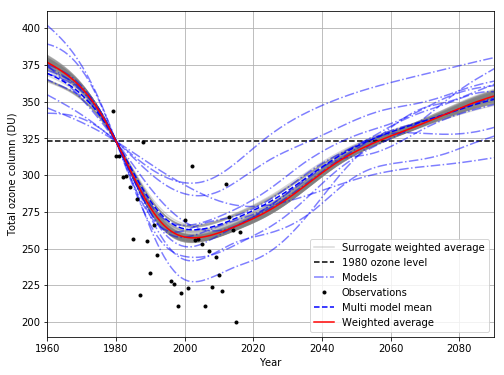

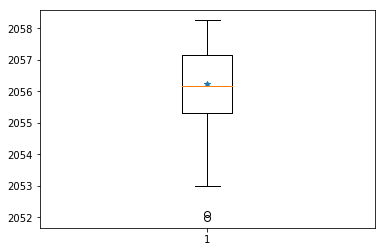

In [31]:
Ws, Ts, dates = return_dates_dropout(mdl_vars, obs_vars, mdl_perms, metric_perms)

## Perfect model testing

In [32]:
def perfect_mdl_testing():

    MSE = []
    MSE_mdls = []
    
    WA_dates = []
    MMM_dates = []
    PM_dates = []

    # For all the models in refC1SD
    for i in range(len(ta_mdls_norm)):

        # Define pseudo-truth 
        ta_pt = ta_mdls_norm[i]
        ta_grad_pt = ta_grad_mdls_norm[i]
        toz_grad_pt = toz_grad_mdls_norm[i]
        hcl_pt = hcl_mdls_norm[i]
        mdl = wf.get_mdls_reals(ta_pt)
        dtozdT_pt = dtozdT_mdls_norm[mdl]
        dtozdtdTdt_pt = dtozdtdTdt_mdls_norm[mdl]
        zmua_pt = zmua_mdls_norm[mdl]

        pm_names = mdl_names.copy()
        pm_names.remove(mdl)

        # Define pseudo-models (all models except the pseudo truth)
        ta_pm = ta_mdls_norm.copy()
        ta_pm.remove(ta_mdls_norm[i])
        ta_grad_pm = ta_grad_mdls_norm.copy()
        ta_grad_pm.remove(ta_grad_mdls_norm[i])
        toz_grad_pm = toz_grad_mdls_norm.copy()
        toz_grad_pm.remove(toz_grad_mdls_norm[i])
        hcl_pm = hcl_mdls_norm.copy()
        hcl_pm.remove(hcl_mdls_norm[i])
        dtozdT_pm = dtozdT_mdls_norm.copy()
        del dtozdT_pm[mdl]
        dtozdtdTdt_pm = dtozdtdTdt_mdls_norm.copy()
        del dtozdtdTdt_pm[mdl]
        zmua_pm = zmua_mdls_norm.copy()
        del zmua_pm[mdl]

        # Independence (this won't change as there is no dependence on the observations)
        S_ta, W_ta = wf.independence(ta_pm, sigma=sigma_s)
        S_ta_grad, W_ta_grad = wf.independence(ta_grad_pm, sigma=sigma_s)
        S_toz_grad, W_toz_grad = wf.independence(toz_grad_pm, sigma=sigma_s)
        S_hcl, W_hcl = wf.independence(hcl_pm, sigma=sigma_s)
        S_zmua, W_zmua = wf.independence_single_value(zmua_pm.values(), sigma=sigma_s)
        S_dtozdT, W_dtozdT = wf.independence_single_value(dtozdT_pm.values(), sigma=sigma_s)
        S_dtozdtdTdt, W_dtozdtdTdt = wf.independence_single_value(dtozdtdTdt_pm.values(), sigma=sigma_s)

        S_list = [S_ta, S_ta_grad, S_toz_grad, S_hcl, S_zmua, S_dtozdT, S_dtozdtdTdt]

        S_ave = np.zeros(S_list[0].shape)
        for s in S_list:
            S_ave += s

        S_ave /= len(S_list)

        W_ave = np.zeros((len(pm_names), 1))

        for ii in range(len(pm_names)):
            w = 1 / (1 + np.nansum(S_ave[ii], 0))
            W_ave[ii] = w

        W_ave /= np.nansum(W_ave)

    #     most_similar_model(S_ave, pm_names)

        W_independence = dict()
        for i, temp_mdl in enumerate(pm_names):
            W_independence[temp_mdl] = W_ave[i]

        # Performacne
        Wd_ta = wf.performance(ta_pm, ta_pt, sigma=sigma_d)
        Wd_ta_grad = wf.performance(ta_grad_pm, ta_grad_pt, sigma=sigma_d)
        Wd_hcl = wf.performance(hcl_pm, hcl_pt, sigma=sigma_d)
        Wd_toz_grad = wf.performance(toz_grad_pm, toz_grad_pt, sigma=sigma_d)
        Wd_zmua = wf.performance_single_value(zmua_pm.values(), zmua_pt, sigma=sigma_d)
        Wd_dtozdT = wf.performance_single_value(dtozdT_pm.values(), dtozdT_pt, sigma=sigma_d)
        Wd_dtozdtdTdt = wf.performance_single_value(dtozdtdTdt_pm.values(), dtozdtdTdt_pt, sigma=sigma_d)

        D_list = [Wd_ta, Wd_ta_grad, Wd_toz_grad, Wd_hcl, Wd_zmua, Wd_dtozdT, Wd_dtozdtdTdt]

        D_ave = np.zeros(D_list[0].shape)
        for d in D_list:
            D_ave += d

        D_ave /= len(D_list)

        D_ave /= np.nansum(D_ave)

        W_tot = (D_ave * W_ave).reshape(-1)

        W_dict = dict()
        for i, w in enumerate(W_tot): 
            W_dict[pm_names[i]] = w

        # Find which model appear both in the weighting and the refC2
        # And test against the pseudo-truth
        refC2_reals = []
        for cube in toz_refC2:
            refC2_reals.append(wf.get_mdls_reals(cube))
        mdl_intersect = np.intersect1d(refC2_reals, pm_names)

        W_intersect = dict()
        for temp_mdl in mdl_intersect:
            W_intersect[temp_mdl] = W_dict[temp_mdl]

        # Normalise the new weights which are left
        w_tot = np.sum(list(W_intersect.values()))
        for key in W_intersect.keys():
            W_intersect[key] = W_intersect[key] / w_tot
        w_cubes = []
        for cube in toz_refC2:
            if wf.get_mdls_reals(cube) in W_intersect.keys():
                w_cubes.append(cube)

        # Define pseudo obs
        cont = False
        for cube in toz_refC2:
            if wf.get_mdls_reals(cube) == mdl:
                pseudo_obs = cube
                cont = True
        pseudo_obs = wf.constrain_year(pseudo_obs, 1960, 2094)
        w_cubes, pseudo_obs = wf.constrain_mdl_obs_time(w_cubes, pseudo_obs)
        time = w_cubes[0].coord('year').points
        we_ave = np.zeros(w_cubes[0].shape)
        MMM = np.zeros(w_cubes[0].shape)
        for cube in w_cubes:
            w = W_intersect[wf.get_mdls_reals(cube)]
            we_ave = we_ave + (w * cube.data)
            MMM = MMM + cube.data
        MMM = MMM / len(w_cubes)


        MSE.append((np.abs(np.nansum((pseudo_obs.data - MMM))) - np.abs((np.nansum((pseudo_obs.data - we_ave)))))/len(MMM))
        MSE_mdls.append(mdl)
        
        # Print the real return dates and the new predicted dates and the ones from the multimodel mean
        funWA = interpolate.interp1d(we_ave[50:], time[50:])
        funMMM = interpolate.interp1d(MMM[50:], time[50:])
        funPM = interpolate.interp1d(pseudo_obs.data[50:], time[50:])

        try:
            PM_dates.append(funPM(0))
        except(ValueError):
            PM_dates.append(np.nan)
        WA_dates.append(funWA(0))
        MMM_dates.append(funMMM(0))
            
        
    print(MSE)   
    plt.figure()
    plt.title(str(sigma_s) + ' ' + str(sigma_d))
    plt.bar(MSE_mdls, MSE, color='b')
    plt.bar(['Average'], [np.nanmean(MSE)], color='r')
    plt.ylabel('Average improvement of prediction (DU)')
    plt.xticks(rotation='vertical')
    plt.grid('True')
    plt.show()
    
    
    return

[-0.09678226069783655, 0.5297591142665169, -0.6534726760331077, -2.6749833955778843, 3.0096143933275927, 1.250002659339215, 2.50558782793497, 4.856266449318144, 0.22205687632425006, 1.4013728923790714, 0.5744982024565156]


/home/amosm1/miniconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


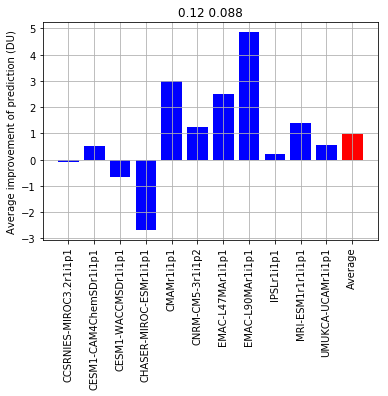

In [33]:
perfect_mdl_testing()

# Deriving Uncertainties

The individual model trends have differences in the background level of the total column ozone. To be able to compare across the ensemble anomally time series are constructed with comparisson to a baseline. The baseline chosen is $t_0 = 1980$

The anomally time series: $y_{jk}(t) - h_j(t_0)$.

It makes more sense however to adjust to the mean ozone level in 1980 across the models ($h(t_0)=mean(h_j(t_0))$) which gives out baseline adjusted time series for each model. 

$y_{jk}'(t) = y_{jk}(t) - h_j(t_0) + h(t_0)$

We can also baseline adjust out smoothed trend for each model:

$h'_j(t) = h_j(t) - h_j(t_0) + h(t_0)$

These are the baseline adjusted refC2 model trends

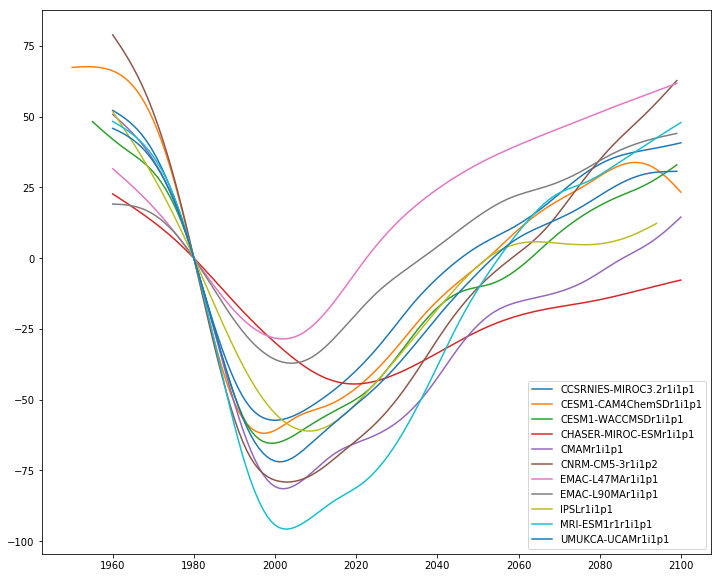

In [34]:
plt.figure(figsize=(12,10))
for i, h_dash in enumerate(baseline_adjusted_h):
    plt.plot(xx, h_dash, label=wf.get_mdls_reals(toz_refC2_temp[i]))
plt.legend()
plt.show()

To make the multi model trend estimates (MMT)

$h'(t) = \sum_{j} w_j(t) h'_j(t)$

where the weights have the properties:

$w_j(t) \geq 0$   and   $\sum_{j} w_j(t) = 1$

This gives the standard error of the weighted sum to be:

$s^{2}_{h}(t) = \sum_{j} w^2_j(t)s^2_j(t)$

where $s_j(t)$ is the standard error in the trend estimate

In [35]:
MMT = np.dot(np.asarray(baseline_adjusted_h).T, W_save) # MMT is the same as we_ave
s_h = np.sqrt(np.dot((np.asarray(W_save) ** 2), (np.asarray(se) ** 2)))

The confidence interval is:

$[h'(t) - 1.96s_h(t), h'(t) + 1.96s_h(t)]$

This interval has a 95% chance of overlapping the true trend and represents the local uncertainty in the trend at each year

In [36]:
ci0 = MMT - 1.96 * s_h
ci1 = MMT + 1.96 * s_h

and the prediction interval is:

$\left[h'(t) - 1.96\sqrt{s_h(t) + s^2_{\epsilon}}, h'(t) + 1.96\sqrt{s_h(t) + s^2_{\epsilon}}\right]$

The 95% prediction interval is a combination of the local uncertainty in the trend and uncertainty due to natural interannual variability about the trend; it gives a sense of where an ozone value for a given year might reasonably lie

In [37]:
e_std = np.nanstd(anoms)
pi0 = MMT - 1.96 * np.sqrt(s_h ** 2 + e_std ** 2)
pi1 = MMT + 1.96 * np.sqrt(s_h ** 2 + e_std ** 2)

Combine the errors for dropout and from the TSAM

In [38]:
comb_err = [np.sqrt(ss**2 + np.std(dates)**2) for ss in s_h]
ci0_c = MMT - 1.96 * np.asarray(comb_err)
ci1_c = MMT + 1.96 * np.asarray(comb_err)

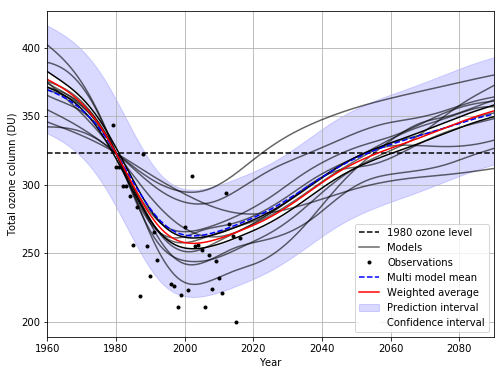

In [39]:
we_ave_tot = we_ave
plt.figure(figsize=(8,6))

# Prediction intervals
plt.fill_between(xx, pi0 + toz_norm, pi1 + toz_norm, color='blue', alpha=0.15, label='Prediction interval')

# Confidence intervals
plt.fill_between(xx, ci0_c + toz_norm, ci1_c + toz_norm, color='white', label='Confidence interval')
plt.plot(xx, ci0_c + toz_norm, 'k')
plt.plot(xx, ci1_c + toz_norm, 'k')

plt.plot([1960, 2090], [toz_norm, toz_norm], linestyle='--', color='black', label='1980 ozone level')
first = True
for cube in w_cubes:
    if first == True:
        first = False
        plt.plot(cube.coord('year').points, cube.data + toz_norm, 'k',label='Models', alpha=0.6)
    else:
        plt.plot(cube.coord('year').points, cube.data + toz_norm, 'k', alpha=0.6)
            
plt.plot(toz.coord('year').points[:14], toz.data[:14], 'k.', label='Observations')
plt.plot(toz.coord('year').points[14:], toz.data[14:], 'k.')
plt.plot(cube.coord('year').points, MMM + toz_norm, color='blue', linestyle='--', label='Multi model mean')
plt.plot(cube.coord('year').points, we_ave + toz_norm, color='red', label='Weighted average')
plt.ylabel('Total ozone column (DU)')
time_fin = cube.coord('year').points


plt.grid(True)
plt.xlim(1960,2090)
plt.legend()
plt.xlabel('Year')

plt.show()